In [1]:
import os 
import sys 

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import torch  
import minari 
import numpy as np

from utils.sampling_states import sample_states
from models.cl_model import mlpCL
from data.TrajectorySet import TrajectorySet


In [2]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu"
PROJECT_ROOT = os.getcwd()

In [3]:
# Get all 4 models 

model_name_1 = "best_model_laplace_15.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_1) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    laplace_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_2 = "best_model_gaussian.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_2) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    gauss_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_3 = "best_model_exponential.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_3) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    expo_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_4 = "best_model_uniform.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_4) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    uniform_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_laplace_15.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_gaussian.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_exponential.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\best_model_uniform.ckpt, loading...


In [4]:
# Get states from dataset
d = sample_states(MINARI_DATASET, 1_000_000, save_n_trajectories=2)

# Preprocessor

In [5]:
def process_states(states) -> list: 
    """
    Takes in raw states and returns its corresponding 2D PCA embedding. 
    Args: 
        states: The raw states, of size [N, d]
    
    Returns: 
        A list of PCA embeddings from the 4 models in this order: 
        [pca_laplace, pca_gauss, pca_expo, pca_uniform]
    """
    # Convert subsampled states to latent represntation 
    new_states = torch.as_tensor(states, dtype=torch.float32)

    with torch.no_grad():
        laplace_z = laplace_model(new_states)
        gauss_z = gauss_model(new_states)
        expo_z = expo_model(new_states) 
        uniform_z = uniform_model(new_states)

    # Normalize representation embeddings 
    scaler = StandardScaler()
    norm_laplace_z = scaler.fit_transform(laplace_z)
    norm_gauss_z = scaler.fit_transform(gauss_z)
    norm_expo_z = scaler.fit_transform(expo_z)
    norm_uniform_z = scaler.fit_transform(uniform_z)

    # PCA 
    pca = PCA(n_components=2)

    pca_laplace = pca.fit_transform(norm_laplace_z)
    pca_gauss = pca.fit_transform(norm_gauss_z)
    pca_expo = pca.fit_transform(norm_expo_z)
    pca_uniform = pca.fit_transform(norm_uniform_z)

    return [pca_laplace, pca_gauss, pca_expo, pca_uniform]


In [6]:
d["states"].shape

(1000000, 4)

In [10]:
states = d["states"]

# Subsample from the states array so there isn't so much clutter on visualization
idx = np.random.choice(np.arange(1_000_000), size=50_000, replace=False)
new_states = states[idx] 

pca_states = process_states(new_states)

t1 = [x[0 : d["trajectory_idx"][0]] for x in pca_states] 
t2 = [x[d["trajectory_idx"][0] : d["trajectory_idx"][1]] for x in pca_states]

print(d["trajectory_idx"])

[185, 257]


C:\Users\ray\AppData\Local\Temp\ipykernel_3456\644620671.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


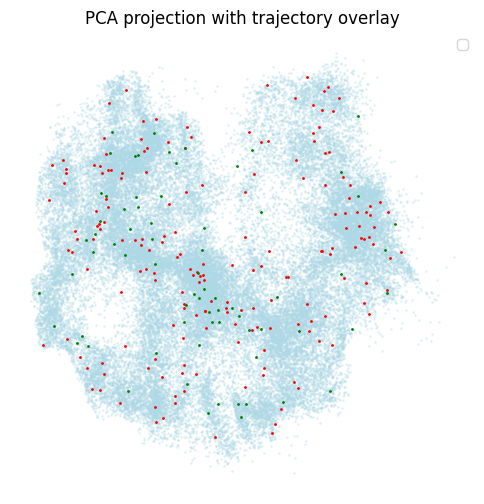

In [14]:
i = 0

plt.figure(figsize=(6,6))
plt.scatter(pca_states[i][:, 0], pca_states[i][:, 1], s=1, c="lightblue", alpha=0.25)
plt.scatter(t1[i][:, 0], t1[i][:, 1], s=1, c="red")
plt.scatter(t2[i][:, 0], t2[i][:, 1], s=1, c="green")


plt.axis("off")
plt.legend()
plt.title("PCA projection with trajectory overlay")
plt.show()

#plt.scatter(pca_gauss[:, 0], pca_gauss[:, 1], s=1, c="red", alpha=0.1)
#plt.scatter(pca_expo[:, 0], pca_expo[:, 1], s=1, c="green", alpha=0.1)
#plt.scatter(pca_uniform[:, 0], pca_uniform[:, 1], s=1, c="purple", alpha=0.1)

